In [4]:
%pylab inline
import pandas
from glob import glob

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/jupyter/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


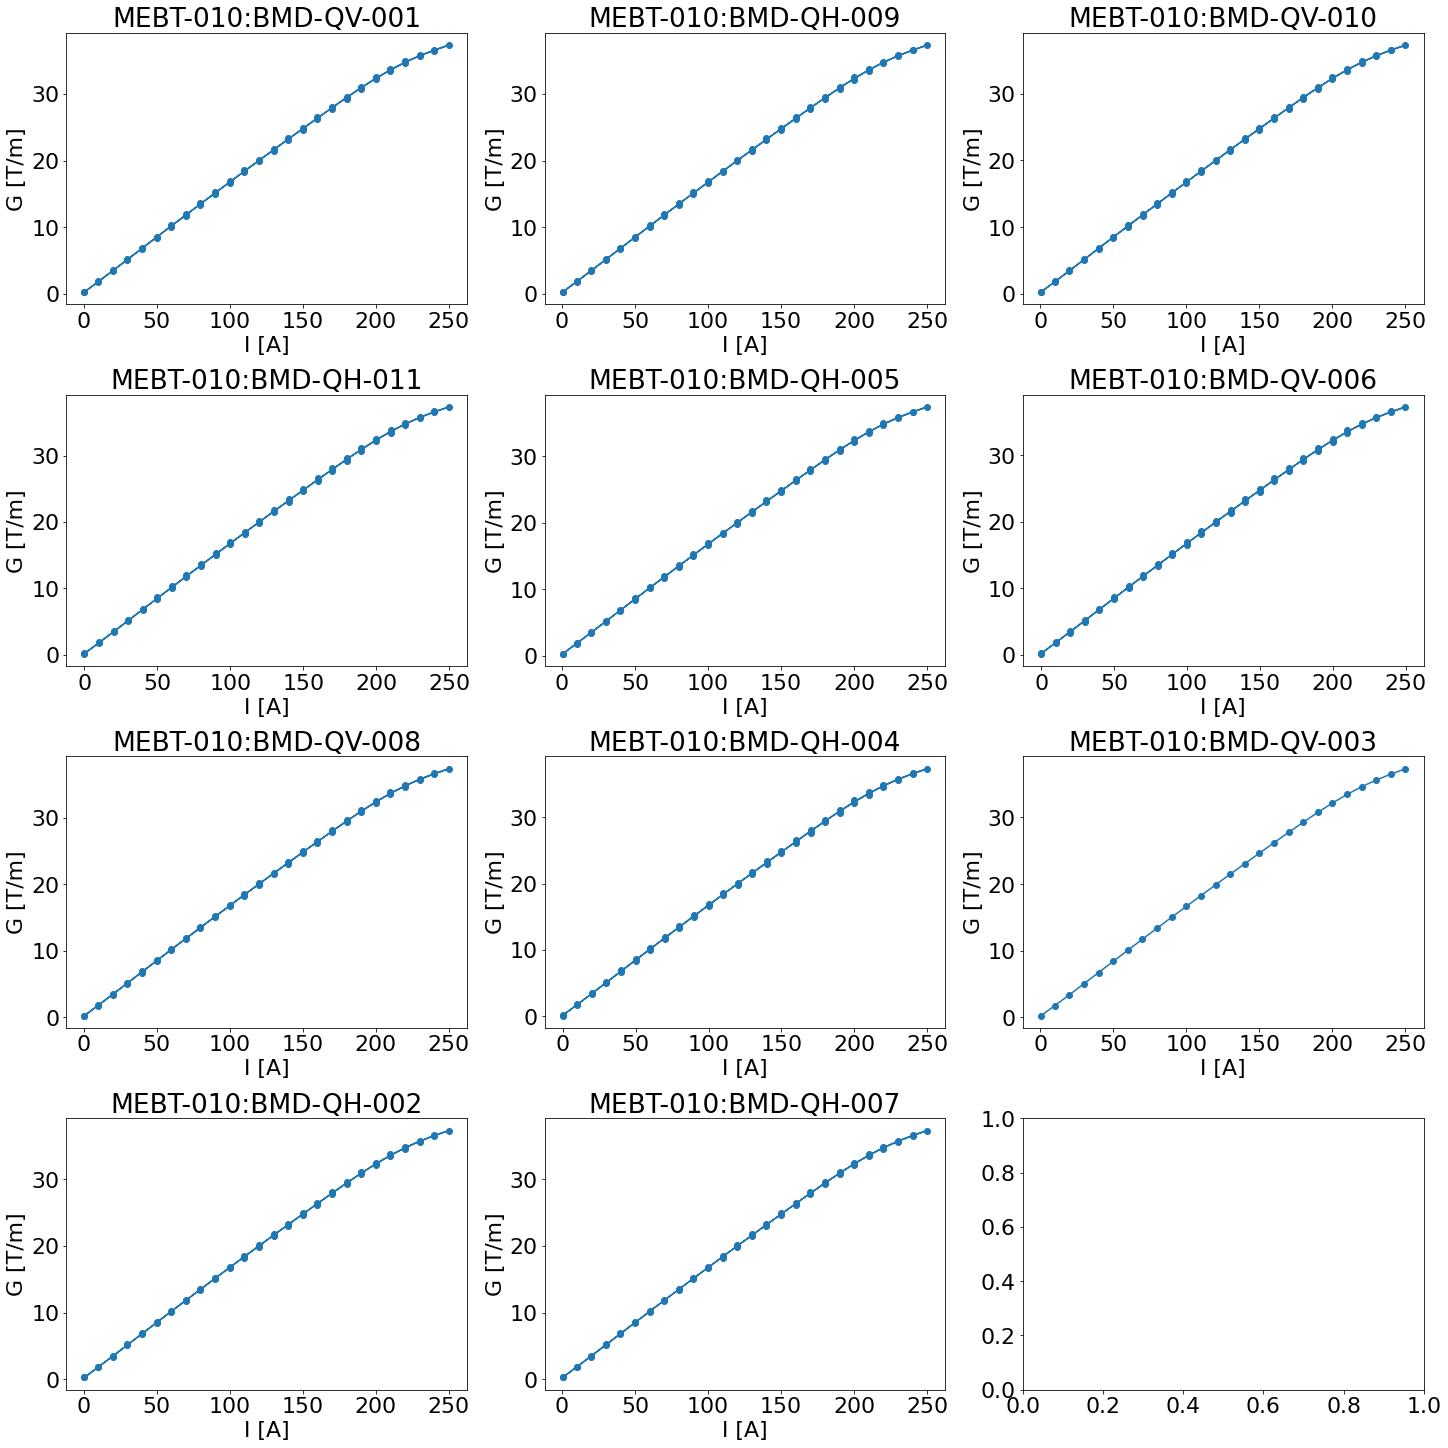

In [5]:
# This cell extract the data from the files and normalize the
# integrated gradient with the data from the simulations.
# It also applies the correct names to the magnets.

names = pandas.read_csv('MEBT quads multipole measurements/Names.txt', header=None)

font = {'size'   : 22}
matplotlib.rc('font', **font)
axs = plt.figure(figsize=(20,20), constrained_layout=True).subplots(4, 3)
plot_number = 0

for data_file in glob('MEBT quads multipole measurements/*.xlsm'):
    raw_data = pandas.read_excel(data_file, sheet_name='Data File', header=None)
    header_length = raw_data[1][0]
    magnet_number = int(raw_data[raw_data[0]=='Magnet nr                               '][1].values)
    _, lines,_ = raw_data[1][header_length+2].replace('[','').replace(']', '').split(',')
    lines=int(lines)
    current = raw_data.loc[header_length+6:header_length+6+lines-1][[0,1,2]]
    current.reset_index(level=0, inplace=True, drop=True)
    current.columns=raw_data.loc[header_length+5][[0,1,2]]
    current = current[' Measured current [A] '].values.astype(numpy.float)
    raw_data = pandas.read_excel(data_file, sheet_name='Result Overview', header=None, skiprows=9)
    int_grad = raw_data[raw_data[0]=='Integ. gradient']
    int_grad = int_grad.values[0][2:].astype(numpy.float)
    int_grad = int_grad[~numpy.isnan(int_grad)]

    magnet_name = names[names[0]==magnet_number][1].values[0]
    
    x = current
    y = int_grad
    fit_coeff = numpy.polyfit(x,y,10)
    normalization = 1/0.0779
    
    x_fit = current
    y_fit = numpy.poly1d(fit_coeff)(x_fit)
    
    axs[plot_number//3,plot_number%3].scatter(x, y*normalization)
    axs[plot_number//3,plot_number%3].plot(x_fit, y_fit*normalization)

    axs[plot_number//3,plot_number%3].set_title(magnet_name)
    axs[plot_number//3,plot_number%3].set_xlabel('I [A]')
    axs[plot_number//3,plot_number%3].set_ylabel('G [T/m]')
    plot_number+=1
plt.show()

In [6]:
#breaktable(typeSdegF) {
#	0.000000 0.000000
#	210.000000 0.0388
#	250.000000 0.0425
#}

# This cell generates the configuration files for the IOCs

names = pandas.read_csv('MEBT quads multipole measurements/Names.txt', header=None)

for data_file in glob('MEBT quads multipole measurements/*.xlsm'):
    raw_data = pandas.read_excel(data_file, sheet_name='Data File', header=None)
    header_length = raw_data[1][0]
    magnet_number = int(raw_data[raw_data[0]=='Magnet nr                               '][1].values)
    _, lines,_ = raw_data[1][header_length+2].replace('[','').replace(']', '').split(',')
    lines=int(lines)
    current = raw_data.loc[header_length+6:header_length+6+lines-1][[0,1,2]]
    current.reset_index(level=0, inplace=True, drop=True)
    current.columns=raw_data.loc[header_length+5][[0,1,2]]
    current = current[' Measured current [A] '].values.astype(numpy.float)
    raw_data = pandas.read_excel(data_file, sheet_name='Result Overview', header=None, skiprows=9)
    int_grad = raw_data[raw_data[0]=='Integ. gradient']
    int_grad = int_grad.values[0][2:].astype(numpy.float)
    int_grad = int_grad[~numpy.isnan(int_grad)]

    magnet_name = names[names[0]==magnet_number][1].values[0]
    
    x = current
    y = int_grad
    fit_coeff = numpy.polyfit(x,y,10)
    normalization = 1/0.0779
    
    x_fit = numpy.arange(0,260,10)
    y_fit = numpy.poly1d(fit_coeff)(x_fit)*normalization
    y_fit[0]=0
    x_fit = append(-flip(x_fit)[:-1],x_fit)*1000
    y_fit = append(-flip(y_fit)[:-1],y_fit)
    
    with open('Files for IOCs/'+magnet_name.replace(':','_')+'.dbd', 'w') as f:
        f.write('breaktable('+magnet_name.replace(':','_')+') {\n')
        for i in range(len(x_fit)):
            f.write('\t{x} {y}\n'.format(x=x_fit[i], y=y_fit[i]))
        f.write('}')